<a href="https://colab.research.google.com/github/antoineodier/pytorchSeminar/blob/master/03_Feedforward_de.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST Dataset

### PyTorch Dataset & DataLoader

PyTorch enthält einige Tools zur effizienten Datenprozessierung.
- Mit Dataset und Dataloader kannst du die Datengenerierung inklusive **Preprocessing** und **Batching** so optimieren, dass nicht alle Daten gleichzeitig im Memory prozessiert werden müssen (**Generators**).
- Ziel: Zufällige Batches von Listen aus Input-Tensoren

Schritte:
1. Auslesen der Daten als Liste von Inputs
2. Mapping nach Float- bzw. Long-Tensoren
3. Shuffling
4. Batching

Zuerst wird eine Dataset-Klasse definiert:
- Die ist von **torch.utils.data.Dataset** abgeleitet ist. 
- Und ist eine abstrakte Klasse.
- Du musst diese beiden  Methoden definieren:
    - **\_\_len\_\_()** zur Berechnung der Size. 
    - **\_\_getitem\_\_()** gibt einen Datensatz zurück.


In [0]:
# Example Dataset Class

import os
import torch
from torch.utils.data import DataLoader, Dataset

class CaliDataset(Dataset):
    """California Housing dataset."""

    def __init__(self, root_dir, data_file, preprocess=None):
        # Here we load the dataset into a dataframe and transform the rows to word sequences
        self.data_file = data_file  # file name
        self.root_dir = root_dir  # root directory
        self.preprocess = preprocess  # pass on an optional preprocessor
        self.file_path = os.path.join(self.root_dir, self.data_file)
        self.tar_path = 'CaliforniaHousing/cal_housing.data'
        self.tarfile = tarfile.open(mode="r:gz", name=self.file_path)
        self.data = self.tarfile.extractfile(self.tar_path)
        self.line_offsets = []
        
        offset = 0
        for line in self.data.readlines(offset):
            self.line_offsets.append(offset)
            offset += len(line)
        
    def __len__(self):
        return len(self.line_offsets)
    
    def __getitem__(self, idx):
        self.data.seek(self.line_offsets[idx])
        line = self.data.readline()
        linel = [float(v) for v in str(line).strip("b\'\\n").split(',')]
        
        x = linel[2:-1]  # skip coordinates
        y = linel[-1:]
        if self.preprocess:  # use a preprocessor
            x, y = self.preprocess(x, y)
        return x, y

### **torch.utils.data.DataLoader** ist ein  Iterator mit folgenden Features:
- Batching der Daten
- Shuffling der Daten
- Laden der Daten optional mit multiprocessing workers



In [0]:
import torch
from torchvision import datasets, transforms

batch_size = 64

# Konvertierung zu PyTorch Tensoren
transform = transforms.Compose([transforms.ToTensor()])

# Download und Laden des Trainingsdatensatzes (60k)
trainset = datasets.FashionMNIST('./FashionMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Download und Laden des Validationsdatensatzes (10k)
validset = datasets.FashionMNIST('./FashionMNIST/', download=True, train=False, transform=transform)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:01, 13239205.03it/s]                              


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 96200.49it/s]                            
0it [00:00, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


4423680it [00:01, 4052881.73it/s]                             
0it [00:00, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw


8192it [00:00, 31681.48it/s]            

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:
!ls  -lh FashionMNIST/*

total 8.0K
drwxr-xr-x 2 root root 4.0K Oct 10 08:34 processed
drwxr-xr-x 2 root root 4.0K Oct 10 08:34 raw


In [0]:
print(len(trainset), len(validset))

60000 10000


60000 10000


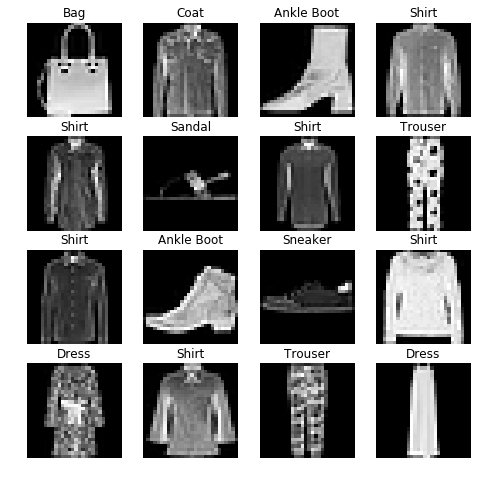

In [0]:
import numpy as np
import matplotlib.pyplot as plt

print(len(trainset), len(validset))


labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8, 8));
columns = 4;
rows = 4;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(trainset));
    img = trainset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[trainset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

In [0]:
# Test trainLoader
# (batches, channels, width, lenght) = (batches, 1, 28, 28)  # gray scale
for i, (images, labels) in enumerate(trainloader):
    print(i, labels.size(), images.size())
    if i>1: break

0 torch.Size([64]) torch.Size([64, 1, 28, 28])
1 torch.Size([64]) torch.Size([64, 1, 28, 28])
2 torch.Size([64]) torch.Size([64, 1, 28, 28])


In [0]:
# Flatten images from 28x28 to 784
# (batches, channels, width,  lenght) = (batch size, 784)  # gray scale
for i, (images, labels) in enumerate(trainloader):
    print(i, labels.size(), images.view(images.size(0), -1).size())
    if i>10: break

0 torch.Size([64]) torch.Size([64, 784])
1 torch.Size([64]) torch.Size([64, 784])
2 torch.Size([64]) torch.Size([64, 784])
3 torch.Size([64]) torch.Size([64, 784])
4 torch.Size([64]) torch.Size([64, 784])
5 torch.Size([64]) torch.Size([64, 784])
6 torch.Size([64]) torch.Size([64, 784])
7 torch.Size([64]) torch.Size([64, 784])
8 torch.Size([64]) torch.Size([64, 784])
9 torch.Size([64]) torch.Size([64, 784])
10 torch.Size([64]) torch.Size([64, 784])
11 torch.Size([64]) torch.Size([64, 784])


# Übung
1. Entwickle ein Feed Forward NN (MLP) aus 3 Hidden Layers mit jeweils einer ReLU Activation. Benutze folgende Templates:


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(Net, self).__init__()
        # Füge nn.Linear() und nn.ReLU() Module hier ein 
        
    def forward(self, x):        
        # Definiere die Forward-Sequenz hier aus den Modulen in __init__()
        return out
    
input_dim = ? 
hidden_dim1 = ?
hidden_dim2 = ?
hidden_dim3 = ?
output_dim = ?

model = Net(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)

# Check Architecture
print(model)

2. Schreibe eine Accuracy-Funktion mit Torch-Tensoren als Eingabe.

In [0]:
def accuracy(y_true, pred):
    # do something here
    return correct/total

3. Definiere eine SGD Optimizer und eine Cross Entropy Loss Funktion.

4. Trainiere das Modell mit demTrainingsdatensatz und  drucke nach jeder Epoche
    - Loss  und Accuracy für den Trainingsdatensatz
    - Loss  und Accuracy für den Validationsdatensatz
    
Benutze diese Templates:

In [0]:
# for plots:
epochs = []
plot_train_losses = []
plot_train_accs = []
plot_val_losses = []
plot_val_accs = []
    
def train_loop(model, trainloader, validloader=None, num_epochs = 20, print_every = 200):
    
    for epoch in range(num_epochs):
        train_losses = []      # stores losses of all batches
        train_accs = []        # stores accuracy of all batches
        val_losses = []  # stores losses of all batches for validation sample
        val_accs = []    # stores losses of all batches for validation sample
    
        # Trainingsschleife
        ...
        loss, preds = train(model, images, labels) ### siehe unten
        acc = accuracy(labels, preds)
        ...
        if (i+1) % print_every == 0:
            print('Training', epoch+1, i+1, loss.item())
        
        if validloader is None:
            continue

        # Validationsschleife
        ...
        loss, preds = valid(model, images, labels)  ### siehe unten
        acc = accuracy(labels, preds)
        ...
        if (i+1) % print_every == 0:
            print('Validation', epoch+1, i+1, loss.item())

        print('--- Epoch, Train-Loss, Valid-Loss:', epoch, np.mean(train_losses), np.mean(val_losses))
        
        

In [0]:
# Training einer Batch
def train(model, images, label, train=True):    
    ...
    return loss, preds
            
# Validierung: Nur Vorwärtslauf ohne Backpropagation
def valid(model, images, label):
    return train(model, images, label, train=False)

5. Plotte Loss und Accuracy vs. Epoche für Training- und Validation--Datasets